In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

In [17]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression

In [3]:
# !pip install xgboost

In [4]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.style.use('ggplot')
plt.rcParams["font.family"] = "Times New Roman"

# Задание - Предсказание уровня экспресси белка

<img src='https://www.researchgate.net/publication/313504607/figure/fig3/AS:459880453677066@1486655453033/Protein-protein-interaction-PPI-network-of-DEGs-by-STRING-The-interaction-score-was.png'>




<div class="alert alert-info">
<b>Про биологию</b>
    
Экспрессия — процесс, в ходе которого наследственная информация от гена (последовательности нуклеотидов ДНК) преобразуется в функциональный продукт — белок. Уровнем экспрессии называют - количество белка, производящегося в этом процессе. Чем выше экспрессия белка, тем большее количество этого белка появляется в клетках человека. 
    
    

<div class="alert alert-info">    
<b>Важность задачи</b>
    
Существует множество причин необходимости в знании уровня экспресии белка. Например - это позволяет ученым разрабатывать лекарственные средства и оптимизировать их разработку. Теперь вам предстоит побыть в роли биоинформатика и помочь науке!
    
</div>


<div class="alert alert-info">
<b>Про Датасет</b>
    
Датасет представляет собой граф взаимойдествия белков. Где узлы это белки, взаимодействие между белками это ребро. 

Для каждого белка известен уровень его экспрессии. Ниже приведен список ребер `edges`. Информация по экспрессии белков, разбитая на `train` и `test`.
   
    
</div>

In [5]:
#Список ребер графа 

edges = pd.read_csv("https://raw.githubusercontent.com/a-milenkin/Otus_HW_protein_expression/main/edges.csv", sep=",") # Подгрузим данные
edges.head()

node_1  node_2
0     344      50
1     344     153
2     344     532
3     344     679
4     344     986

In [6]:
#Подгрузим тренирочную выборку
train = pd.read_csv("https://raw.githubusercontent.com/a-milenkin/Otus_HW_protein_expression/main/train.csv", sep=",") # Подгрузим данные
display(train.head(), len(train))

target   node
0  0.251968  11142
1  0.689541   2243
2  0.678245  15514
3  0.272500  20944
4  0.248888   8721

8000

In [7]:
# Подгрузим отложенную выборку для валидации
test = pd.read_csv("https://raw.githubusercontent.com/a-milenkin/Otus_HW_protein_expression/main/test.csv", sep=",")
display(test.head(), len(test))

target   node
0  0.279231    817
1  0.380795   9574
2  0.686527   1607
3  0.303594   4782
4  0.367374  24125

2000

<div class="alert alert-info">
<b>Про Задачу</b>
    
Вам предлагается предсказать экспрессию белков (`target`) по приведенным данным для отложенной выборки. Ответы в отложенной выборке `test` даны вам для самостоятельной валидации.


    
   
    

<div class="alert alert-info">
<b>Замечание и комментарии</b>
    
    

По ряду причин датасет был упрощен так, чтобы выполнялись следующие условия:
* у графа одна компонента связанности. 
* удалены слишком крупные хабы
* плотность связей графа уменьшена
* решить задачу можно классическими ML подходами
    
   

<div class="alert alert-info">
<b>Оценка результатов</b>
    


Оценка точности модели будет оцениваться по метрике MSE на отложенной выборке `test`
        
</div>

<div class="alert alert-info">
<b>Автор задачи</b>

По всем дополнительным вопросами писать Александру Миленькину
* Телеграмм: Alerin75infskin
* Почта: milenkin.aa@phystech.edu
        
</div>

=========================================================================================================

# Создание графа и генерация признаков

In [8]:
G = nx.Graph()
edges = edges.values.tolist()
G.add_edges_from(edges)

## Генерация признаков для узлов

In [9]:
closeness = nx.closeness_centrality(G)
eigenvector = nx.eigenvector_centrality(G)
clustering = nx.clustering(G)
degree = dict(G.degree())

## датафрейм с признаками для узлов

In [10]:
graph_features = pd.DataFrame({
    'node': list(G.nodes()),
    'degree': [degree[node] for node in G.nodes()],
    'clustering': [clustering[node] for node in G.nodes()],
    'closeness': [closeness[node] for node in G.nodes()],
    'eigenvector': [eigenvector[node] for node in G.nodes()]
})

In [11]:
train = pd.merge(train, graph_features, on='node', how='left')
test = pd.merge(test, graph_features, on='node', how='left')

# EDA

In [ ]:
# Корреляционная матрица для признаков

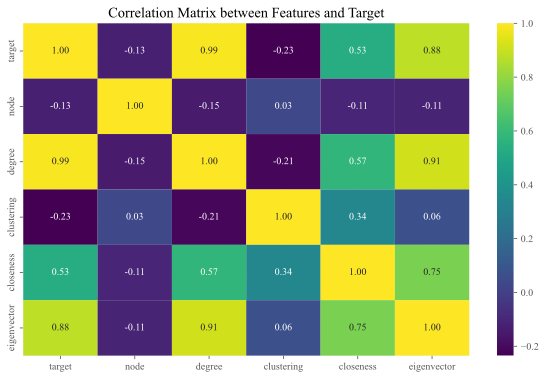

In [12]:
plt.figure(figsize=(10, 6))
correlation_matrix = train.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='viridis', fmt=".2f")
plt.title('Correlation Matrix between Features and Target')
plt.show()

In [13]:
fig, ax = plt.subplots(2, 2, figsize=(18, 12))
ax1, ax2, ax3, ax4 = ax.flatten()

ax1.set_title("Degree vs Target", fontsize=14)
ax1.set_xlabel('Degree', fontsize=12)
ax1.set_ylabel('Target', fontsize=12)
ax1.scatter(train['degree'], train['target'], edgecolors='white', s=55, c='dimgray')

ax2.set_title("Clustering vs Target", fontsize=14)
ax2.set_xlabel('Clustering', fontsize=12)
ax2.set_ylabel('Target', fontsize=12)
ax2.scatter(train['clustering'], train['target'], edgecolors='white', s=55, c='dimgray')

ax3.set_title("Closeness vs Target", fontsize=14)
ax3.set_xlabel('Closeness', fontsize=12)
ax3.set_ylabel('Target', fontsize=12)
ax3.scatter(train['closeness'], train['target'], edgecolors='white', s=55, c='dimgray')

ax4.set_title("Eigenvector vs Target", fontsize=14)
ax4.set_xlabel('Eigenvector', fontsize=12)
ax4.set_ylabel('Target', fontsize=12)
ax4.scatter(train['eigenvector'], train['target'], edgecolors='white', s=55, c='dimgray')

fig.subplots_adjust(hspace=0.3, wspace=0.3)
plt.show()

======================================================================================================

# Modeling

In [65]:
# XGBOOST

In [59]:
features = ['degree',
            'clustering',
            'closeness',
            'eigenvector'
           ]
X_train = train[features]
y_train = train['target']

X_test = test[features]
y_test = test['target']

In [60]:
param_grid_xgb = {
    'n_estimators': [200, 250, 300, 350, 400],
    'learning_rate': [0.025, 0.005, 0.01, 0.015],
    'max_depth': [3, 4, 5, 6]
}

xgb_model = XGBRegressor(objective='reg:squarederror', random_state=13)

In [61]:
grid_search_xgb = GridSearchCV(estimator=xgb_model, param_grid=param_grid_xgb, scoring='neg_mean_squared_error', cv=5, verbose=1)
grid_search_xgb.fit(X_train, y_train)

Fitting 5 folds for each of 80 candidates, totalling 400 fits


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=13, ...),
             param_grid={'learning_rate': [0.025, 0.005, 0.01, 0.015],
                         'max_depth': [3, 4, 5, 6],
                         'n_estimators': [200, 250, 300, 350, 400]},
             scoring='neg_mean_squared_error', verbose=1)

In [62]:
# Оценка на тренировочных данных
train_preds = grid_search_xgb.predict(X_train)
train_mse = mean_squared_error(y_train, train_preds)
train_r2 = r2_score(y_train, train_preds)
print(f"Лучшие параметры XGBoost: {grid_search_xgb.best_params_}")
print(f"Train MSE: {train_mse}, Train R²: {train_r2}")

Лучшие параметры XGBoost: {'learning_rate': 0.025, 'max_depth': 4, 'n_estimators': 400}
Train MSE: 0.017557613896873984, Train R²: 0.9612314470961273


In [79]:
test_preds = grid_search_xgb.predict(X_test)
# Оценка на тестовых данных
test_mse = mean_squared_error(y_test, test_preds)
test_r2 = r2_score(y_test, test_preds)
print(f"Test MSE: {test_mse}, Test R²: {test_r2}")

Test MSE: 0.0260699520325849, Test R²: 0.9653364208602766


In [92]:
def plot_true_vs_pred(y_true, y_pred, title="Предсказания"):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_true, y_pred,  edgecolors='white', s=55, c='dimgray')
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'k--', lw=2)
    plt.title(f'True vs Predicted Values ({title})')
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.tight_layout()
    plt.show()

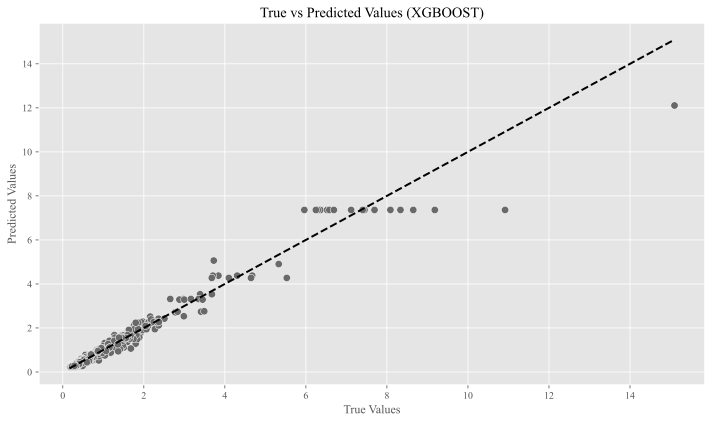

In [93]:
plot_true_vs_pred(y_test, test_preds, "XGBOOST")

----------------------------------------------------------------------------------------------------

In [84]:
# RAndomForest

In [80]:
param_grid_rf = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 4, 6, 8, 10],
    'min_samples_split': [2, 3, 5]
}

In [82]:
rf_model = RandomForestRegressor(random_state=42)
grid_search_rf = GridSearchCV(estimator=rf_model, param_grid=param_grid_rf, scoring='neg_mean_squared_error', cv=5, verbose=1)
grid_search_rf.fit(X_train, y_train)
print(f"Лучшие параметры RandomForest: {grid_search_rf.best_params_}")

Fitting 5 folds for each of 45 candidates, totalling 225 fits
Лучшие параметры RandomForest: {'max_depth': 8, 'min_samples_split': 2, 'n_estimators': 50}


In [85]:
# Шаг 2: Предсказания на тренировочных данных
train_preds_rf = grid_search_rf.predict(X_train)
train_mse_rf = mean_squared_error(y_train, train_preds_rf)
train_r2_rf = r2_score(y_train, train_preds_rf)

test_preds_rf = grid_search_rf.predict(X_test)
test_mse_rf = mean_squared_error(y_test, test_preds_rf)
test_r2_rf = r2_score(y_test, test_preds_rf)

print(f"Train MSE (RandomForest): {train_mse_rf}, Train R²: {train_r2_rf}")
print(f"Test MSE (RandomForest): {test_mse_rf}, Test R²: {test_r2_rf}")

Train MSE (RandomForest): 0.004700534705945321, Train R²: 0.9896208602436362
Test MSE (RandomForest): 0.016530237485005178, Test R²: 0.9780207806081228


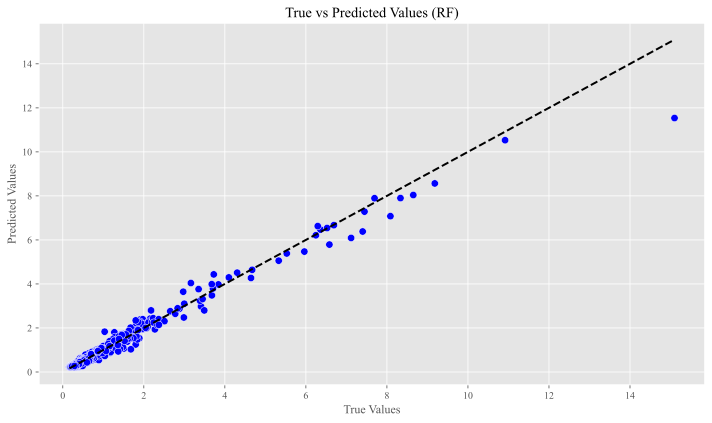

In [86]:
plot_true_vs_pred(y_test, test_preds_rf, "RF")

In [ ]:
linreg_model = LinearRegression()
linreg_model.fit(X_train, y_train)

In [ ]:
train_preds_lr = linreg_model.predict(X_train)
train_mse_lr = mean_squared_error(y_train, train_preds_lr)
train_r2_lr = r2_score(y_train, train_preds_lr)

test_preds_lr = linreg_model.predict(X_test)
test_mse_lr = mean_squared_error(y_test, test_preds_lr)
test_r2_lr = r2_score(y_test, test_preds_lr)

print(f"Train MSE (LinearRegression): {train_mse_lr}, Train R²: {train_r2_lr}")
print(f"Test MSE (LinearRegression): {test_mse_lr}, Test R²: {test_r2_lr}")

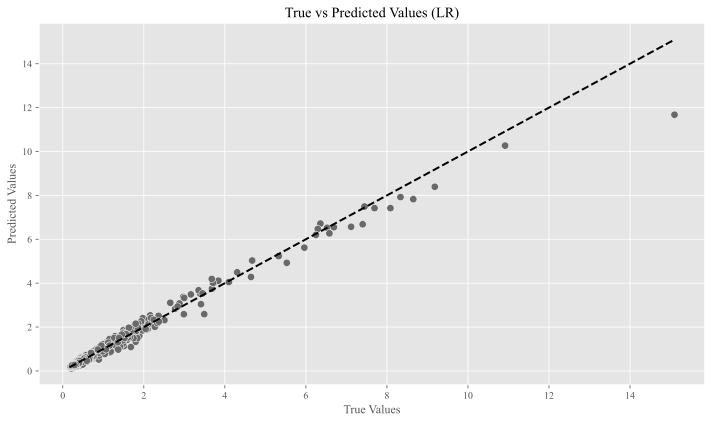

In [94]:
plot_true_vs_pred(y_test, test_preds_lr, title="LR")